## Lectura 7-1: Regresión Lineal Múltiple

En las dos últimas lecturas vimos cómo ajustar un modelo que suponía una relación lineal entre una variable de respuesta y una única variable predictora. En concreto, definimos el modelo de regresión lineal simple,

$$ Y_i = \beta_0 + \beta_1 x_i + \epsilon_i $$

donde $\epsilon_i \sim N(0, \sigma^2)$.

Sin embargo, rara vez se da el caso de que un conjunto de datos tenga una única variable de predicción. Tampoco es frecuente que una variable de respuesta dependa de una única variable. En esta lectura, ampliaremos nuestro modelo lineal actual para permitir que una respuesta dependa de *múltiples* predictores.

### Significado "lineal"

El término "lineal" en los modelos de regresión hace referencia al hecho de que los parámetros se incorporan en la ecuación de forma lineal, no a que necesariamente la relación entre cada predictor y la variable respuesta tenga que seguir un patrón lineal.

La siguiente ecuación muestra un modelo lineal en el que el predictor  $x_1$ no es lineal respecto a $y$:

![image.png](../Images/MLR_1.png)

En contraposición, el siguiente no es un modelo lineal:

$$ y = \beta_0 + \beta_1x_1^{\beta_2} + \epsilon$$ 

En ocasiones, algunas relaciones no lineales pueden transformarse de forma que se pueden expresar de manera lineal:

$$y = \beta_0x_1^{\beta_1}\epsilon$$
 
$$ log(y)=log(\beta_0) + \beta_1log(x_1) + log(\epsilon)$$

**A seguir, vamos a visualizar la base de datos que nos servirá de ejemplo para esta lectura.**


Analizaremos de nuevo un conjunto de datos con información sobre coches. Este conjunto de datos, que se puede encontrar en el [Repositorio de Aprendizaje Automático de la UCI](https://archive.ics.uci.edu/dataset/9/auto+mpg), contiene una variable de respuesta mpg que almacena la eficiencia de combustible en ciudad de los coches, así como varias variables predictoras de los atributos de los vehículos. Cargamos los datos y realizamos algunos ajustes básicos antes de pasar al análisis.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Read the data
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ["mpg", "cyl", "disp", "hp", "wt", "acc", "year", "origin", "name"]
autompg = pd.read_csv(url, sep="\s+", header=None, names=column_names)

In [2]:
# Clean the data
autompg = autompg[autompg['hp'] != '?']
autompg['hp'] = pd.to_numeric(autompg['hp'])
autompg = autompg[autompg['name'] != 'plymouth reliant']
autompg.index = autompg['cyl'].astype(str) + " cylinder " + autompg['year'].astype(str) + " " + autompg['name']
autompg = autompg[["mpg", "cyl", "disp", "hp", "wt", "acc", "year"]]

In [3]:
autompg.head()

,mpg,cyl,disp,hp,wt,acc,year
8 cylinder 70 chevrolet chevelle malibu,18.0,8,307.0,130.0,3504.0,12.0,70
8 cylinder 70 buick skylark 320,15.0,8,350.0,165.0,3693.0,11.5,70
8 cylinder 70 plymouth satellite,18.0,8,318.0,150.0,3436.0,11.0,70
8 cylinder 70 amc rebel sst,16.0,8,304.0,150.0,3433.0,12.0,70
8 cylinder 70 ford torino,17.0,8,302.0,140.0,3449.0,10.5,70


In [4]:
autompg.describe()

,mpg,cyl,disp,hp,wt,acc,year
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,23.419487,5.479487,194.716667,104.574359,2980.353846,15.547692,75.953846
std,7.815625,1.706886,104.825696,38.561917,850.689476,2.762684,3.675518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.000000,4.000000,105.000000,75.000000,2223.750000,13.800000,73.000000
50%,22.450000,4.000000,151.000000,94.500000,2811.000000,15.500000,76.000000
75%,29.000000,8.000000,293.250000,128.000000,3618.250000,17.075000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


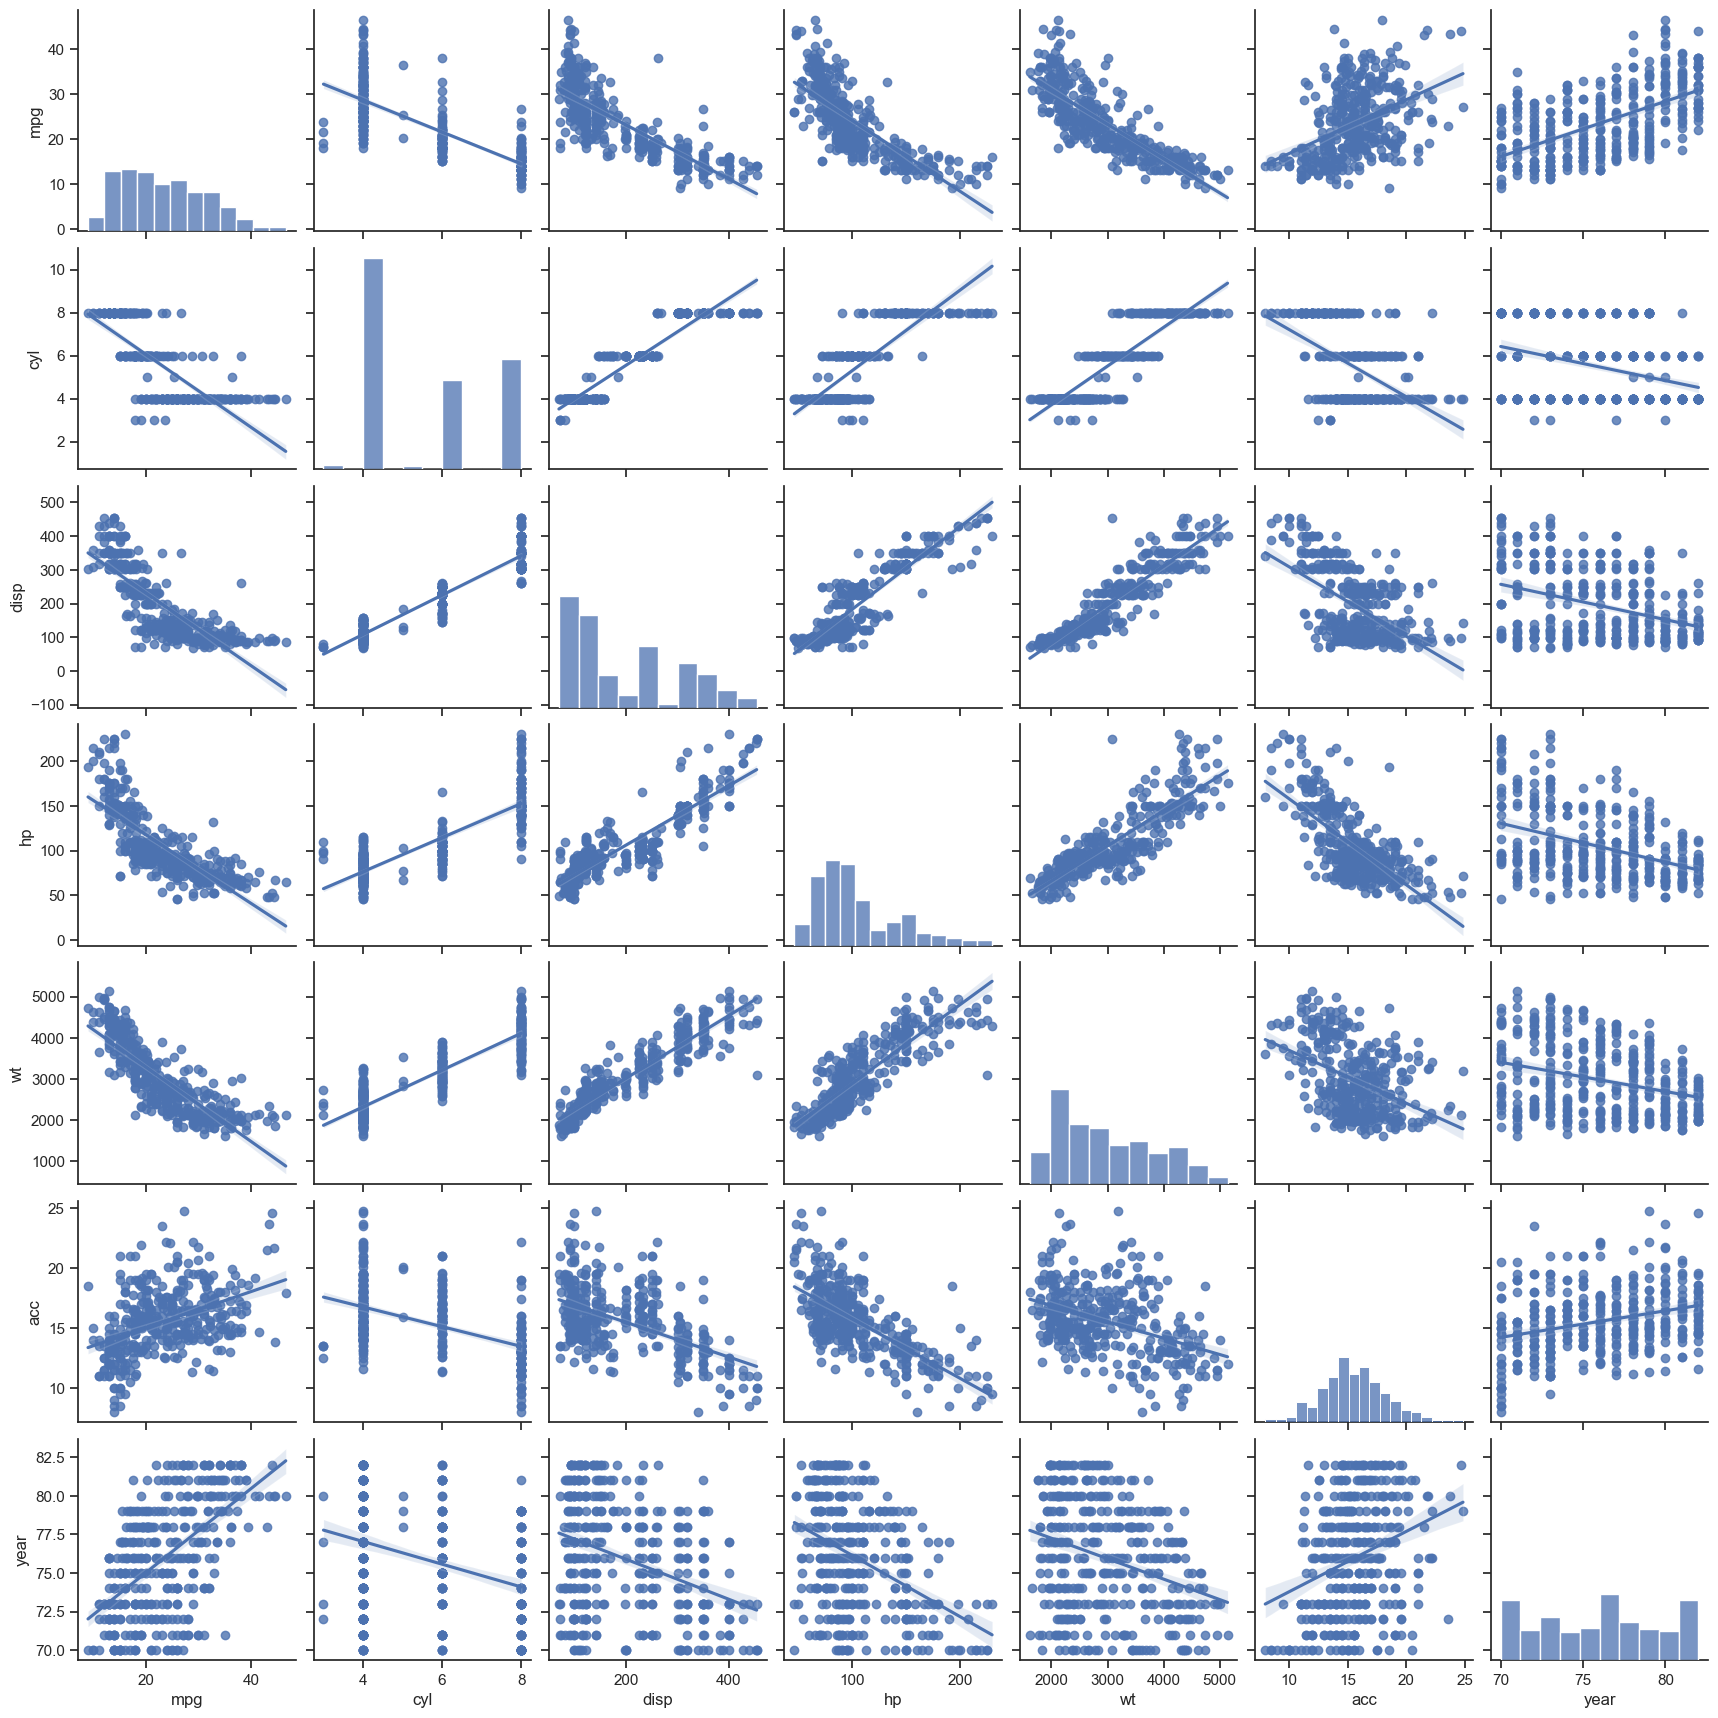

In [5]:
# EDA
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
sns.pairplot(autompg, kind="reg")
#put correlation matrix here
plt.show()




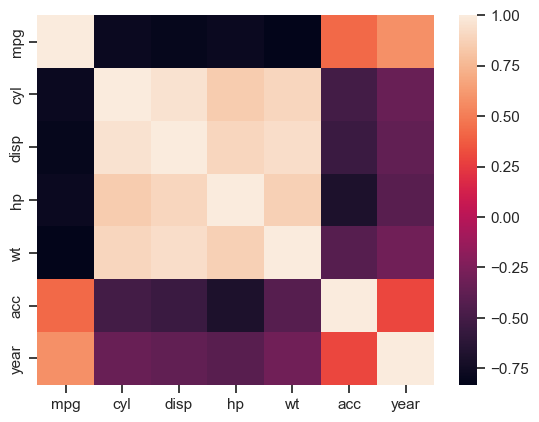

In [6]:
# Plot correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
corr = autompg.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()




Por ahora nos centraremos en utilizar dos variables, peso y año, como variables predictoras. Es decir, nos gustaría modelar la eficiencia de combustible (mpg) de un coche en función de su peso (wt) y el año del modelo (year). Para ello, definiremos el siguiente modelo lineal,

$$ Y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \epsilon_i, \qquad i = 1, 2, \ldots, n$$ 

Donde, $\epsilon_i \sim N(0, \sigma^2)$. En nuestra notación definimos:

$x_{i1}$ como el peso (wt) del carro i.

$x_{i1}$ como el año del modelo (year) del carro i.

existen ahora en un espacio tridimensional, por lo que en lugar de ajustar una recta a los datos, ajustaremos un plano. (Pronto pasaremos a dimensiones superiores, así que éste será el último ejemplo fácil de visualizar y pensar de esta manera).

![image.png](../Images/MLR_2.png)

¿Cómo encontrar ese plano? Pues bien, queremos un plano que esté lo más cerca posible de los puntos de datos. Es decir, que minimice los errores que comete. ¿Cómo definiremos estos errores? Por supuesto, la distancia al cuadrado. Así que nos gustaría minimizar



$$
f(\beta_0, \beta_1, \beta_2) = \sum_{i = 1}^{n}(y_i - (\beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2}))^2
$$


con respecto a $\beta_0$, $\beta_1$, y $\beta_2$. ¿Cómo lo hacemos? Es otro problema sencillo de cálculo multivariante. Todo lo que hemos hecho es añadir una variable extra desde que lo hicimos la última vez. Así que de nuevo, tomamos una derivada con respecto a cada uno de $\beta_0$, $\beta_1$, y $\beta_2$ y ponerlos igual a cero, a continuación, resolver el sistema resultante de ecuaciones. Es decir,




$$
\begin{aligned}
\frac{\partial f}{\partial \beta_0} &= 0 \\
\frac{\partial f}{\partial \beta_1} &= 0 \\
\frac{\partial f}{\partial \beta_2} &= 0
\end{aligned}
$$



Una vez hecho esto, obtendremos de nuevo las **ecuaciones normales.**




$$
\begin{aligned}
n \beta_0 + \beta_1 \sum_{i = 1}^{n} x_{i1} + \beta_2 \sum_{i = 1}^{n} x_{i2} &= \sum_{i = 1}^{n} y_i  \\
\beta_0 \sum_{i = 1}^{n} x_{i1} + \beta_1 \sum_{i = 1}^{n} x_{i1}^2 + \beta_2 \sum_{i = 1}^{n} x_{i1}x_{i2} &= \sum_{i = 1}^{n} x_{i1}y_i \\
\beta_0 \sum_{i = 1}^{n} x_{i2} + \beta_1 \sum_{i = 1}^{n} x_{i1}x_{i2} + \beta_2 \sum_{i = 1}^{n} x_{i2}^2 &= \sum_{i = 1}^{n} x_{i2}y_i
\end{aligned}
$$



Ahora tenemos tres ecuaciones y tres variables, que podríamos resolver, o simplemente dejar que `Python` 
resuelva por nosotros.


In [7]:
# Create linear regression model
X = autompg[["wt", "year"]]
X = sm.add_constant(X)  # Adds a constant (intercept) to the predictor
y = autompg['mpg']

model = sm.OLS(y, X).fit()

# get the coefficients
model.params

const   -14.637642
wt       -0.006635
year      0.761402
dtype: float64

El modelo de regresión obtenido es el siguiente: 


$$\hat{y} = -14.197982 + -0.006664 x_1 + 0.756572 x_2$$



Los principales elementos que hay que interpretar en un modelo de regresión lineal son los coeficientes de los predictores:

-**$\beta_0$**: es la ordenada en el origen o intercept, se corresponde con el valor esperado de la variable respuesta  y   cuando todos los predictores son cero.

-**$\beta_j$**:los coeficientes de regresión parcial de cada predictor indican el cambio promedio esperado de la variable respuesta  y al incrementar en una unidad de la variable predictora $x_j$, manteniéndose constantes el resto de variables.

La magnitud de cada coeficiente parcial de regresión depende de las unidades en las que se mida la variable predictora a la que corresponde, por lo que su magnitud no está asociada con la importancia de cada predictor.

Para poder determinar qué impacto tienen en el modelo cada una de las variables, se emplean los coeficientes parciales estandarizados, que se obtienen al estandarizar (sustraer la media y dividir entre la desviación estándar) las variables predictoras previo ajuste del modelo. En este caso,  $\beta_0$ se corresponde con el valor esperado de la variable respuesta cuando todos los predictores se encuentran en su valor promedio, y  $\beta_j$  el cambio promedio esperado de la variable respuesta al incrementar en una desviación estándar la variable predictora  $x_j$, manteniéndose constantes el resto de variables.


***Para el caso de nuestro ejemplo, donde no tenemos las variables estandardizadas, tenemos la siguiente interpretación de los coeficientes:***

- Aquí, $\hat{\beta}_0 = -14.197$ es nuestra estimación para $\beta_0$, la media de millas por galón para un coche que pesa 0 libras y fue construido en 1900. Vemos que nuestra estimación es negativa, lo que es físicamente imposible. Sin embargo, esto no es inesperado, ya que no podemos esperar que nuestro modelo sea preciso para los coches de 1900 que pesan 0 libras. (¡Porque nunca existieron!) Esto no supone un gran cambio con respecto al SLR. Es decir, $\beta_0$ sigue siendo simplemente la media cuando todos los predictores son 0.

- La interpretación de los coeficientes delante de nuestros predictores es ligeramente diferente a la anterior. Por ejemplo $\hat{\beta}_1 = -0.00664$ es nuestra estimación para $\beta_1$, el cambio medio en millas por galón para un aumento de peso ($x_{1}$) de una libra **para un coche de un determinado año modelo**, es decir, para un valor fijo de $x_{2}$. 

- Obsérvese que este coeficiente es en realidad el mismo para cualquier valor dado de $x_{2}$. Más adelante estudiaremos modelos que permiten un cambio diferente en la respuesta media para distintos valores de $x_{2}$. Tenga en cuenta también que esta estimación es negativa, lo que cabría esperar ya que, en general, la eficiencia del combustible disminuye para los vehículos más grandes. 

    - Recordemos que en la configuración de regresión lineal múltiple, esta interpretación depende de un valor fijo para $x_{2}$, es decir, "para un coche de un determinado año modelo". Es posible que la relación indirecta entre la eficiencia de combustible y el peso no se mantiene cuando un factor adicional, por ejemplo el año, se incluye, y por lo tanto podríamos tener el signo de nuestro coeficiente invertido.

- Por último, $\hat{\beta}_2 =0.761402`$ es nuestra estimación para $\beta_2$, el cambio medio en millas por galón para un aumento de un año en el año del modelo ($x_{2}$) para un coche de un cierto peso, es decir, para un valor fijo de $x_{1}$. No es sorprendente que la estimación sea positiva. Es de esperar que, con el paso del tiempo y los años, la tecnología mejore, de modo que un coche de un peso determinado obtenga ahora mejor kilometraje que sus predecesores. Y, sin embargo, el coeficiente podría haber sido negativo porque también estamos incluyendo el peso como variable, y no estrictamente como valor fijo.



## Enfoque matricial de la regresión

En nuestro ejemplo anterior utilizamos dos variables predictoras, pero sólo nos llevará un poco más de trabajo permitir un número arbitrario de variables predictoras y derivar sus estimaciones de coeficientes. Podemos considerar el modelo



$$ Y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_{p-1} x_{i(p-1)} + \epsilon_i, \qquad i = 1, 2, \ldots, n $$



donde $\epsilon_i \sim N(0, \sigma^2)$. En este modelo, hay $p - 1$ variables predictoras, $x_1, x_2, \cdots, x_{p-1}$. Hay un total de $p$ $\beta$ -parámetros y un único parámetro $\sigma^2$ para la varianza de los errores. (Cabe señalar que casi con la misma frecuencia, los autores utilizan $p$ como el número de predictores, haciendo que el número total de parámetros $\beta$ $p+1$. Esto es algo que siempre hay que tener en cuenta cuando se lee sobre regresión múltiple. No hay una norma que se utilice con más frecuencia).

Si tuviéramos que apilar las $n$ ecuaciones lineales que representan cada $Y_i$ en un vector columna, obtenemos lo siguiente.



$$
\begin{bmatrix}
Y_1   \\
Y_2   \\
\vdots\\
Y_n   \\
\end{bmatrix}
=
\begin{bmatrix}
1      & x_{11}    & x_{12}    & \cdots & x_{1(p-1)} \\
1      & x_{21}    & x_{22}    & \cdots & x_{2(p-1)} \\
\vdots & \vdots    & \vdots    &  & \vdots \\
1      & x_{n1}    & x_{n2}    & \cdots & x_{n(p-1)} \\
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_{p-1} \\
\end{bmatrix}
+
\begin{bmatrix}
\epsilon_1   \\
\epsilon_2   \\
\vdots\\
\epsilon_n   \\
\end{bmatrix}
$$




$$ Y = X \beta + \epsilon $$

Donde

$$
Y = \begin{bmatrix} Y_1 \\ Y_2 \\ \vdots\\ Y_n \end{bmatrix}, \quad
X = \begin{bmatrix}
1      & x_{11}    & x_{12}    & \cdots & x_{1(p-1)} \\
1      & x_{21}    & x_{22}    & \cdots & x_{2(p-1)} \\
\vdots & \vdots    & \vdots    &  & \vdots \\
1      & x_{n1}    & x_{n2}    & \cdots & x_{n(p-1)} \\
\end{bmatrix}, \quad
\beta = \begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_{p-1} \\
\end{bmatrix}, \quad
\epsilon = \begin{bmatrix} \epsilon_1 \\ \epsilon_2 \\ \vdots\\ \epsilon_n \end{bmatrix}
$$



Así que ahora con los datos,

$$y = \begin{bmatrix} y_1 \\ y_2 \\ \vdots\\ y_n \end{bmatrix}$$


Igual que antes, podemos estimar $\beta$ minimizando,

$$ f(\beta_0, \beta_1, \beta_2, \cdots, \beta_{p-1}) = \sum_{i = 1}^{n}(y_i - (\beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_{p-1} x_{i(p-1)}))^2, $$


lo que requeriría tomar $p$ derivadas, que resultan en las
siguientes **ecuaciones normales**.

$$
\begin{bmatrix}
n                           & \sum_{i = 1}^{n} x_{i1}           & \sum_{i = 1}^{n} x_{i2}           & \cdots & \sum_{i = 1}^{n} x_{i(p-1)}       \\
\sum_{i = 1}^{n} x_{i1}     & \sum_{i = 1}^{n} x_{i1}^2         & \sum_{i = 1}^{n} x_{i1}x_{i2}     & \cdots & \sum_{i = 1}^{n} x_{i1}x_{i(p-1)} \\
\vdots                      & \vdots                            & \vdots                            &        & \vdots                            \\
\sum_{i = 1}^{n} x_{i(p-1)} & \sum_{i = 1}^{n} x_{i(p-1)}x_{i1} & \sum_{i = 1}^{n} x_{i(p-1)}x_{i2} & \cdots & \sum_{i = 1}^{n} x_{i(p-1)}^2     \\
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\vdots \\
\beta_{p-1} \\
\end{bmatrix}
=
\begin{bmatrix}
\sum_{i = 1}^{n} y_i \\
\sum_{i = 1}^{n} x_{i1}y_i \\
\vdots \\
\sum_{i = 1}^{n} x_{i(p-1)}y_i \\
\end{bmatrix}
$$


Las ecuaciones normales pueden escribirse mucho más sucintamente en notación matricial,
$$ \left(  X^\top X  \right)\hat{\beta} = X^\top y $$

Podemos entonces resolver esta expresión multiplicando ambos lados por la inversa de $X^\top X$, que existe, siempre que las columnas de $X$ sean linealmente independientes. Entonces, como siempre, denotamos nuestra solución con un sombrero.

$$ \hat{\beta} = \left(  X^\top X  \right)^{-1}X^\top y $$

Para verificar que esto es lo que `Python` ha hecho por nosotros en el caso de dos predictores, creamos una matriz $X$. Obsérvese que la primera columna contiene todos los 1s, y las columnas restantes contienen los datos.


In [8]:
import numpy as np
import statsmodels.api as sm

# Get the number of observations (n) and number of predictors (p)
n = len(autompg)
p = len(model.params)  # Assuming you've trained an OLS model and named it `model`

# Construct X matrix and y vector
X = np.column_stack((np.ones(n), autompg['wt'], autompg['year']))
y = autompg['mpg'].values

# Calculate beta_hat manually
beta_hat_manual = np.linalg.inv(X.T @ X) @ X.T @ y

# Print beta_hat
print(beta_hat_manual)

# Print coefficients from the trained model
print(model.params)


[-1.46376419e+01 -6.63487587e-03  7.61401955e-01]
const   -14.637642
wt       -0.006635
year      0.761402
dtype: float64



$$ \hat{\beta} = \begin{bmatrix}
-14.197982    \\
-0.006664    \\
0.756572    \\
\end{bmatrix}
$$

En nuestra nueva notación, los valores ajustados pueden escribirse

$$\hat{y} = X \hat{\beta}.$$

$$ \hat{y} = \begin{bmatrix} \hat{y}_1 \\ \hat{y}_2 \\ \vdots\\ \hat{y}_n \end{bmatrix} $$

A continuación, podemos crear un vector para los valores residuales,

$$e 
= \begin{bmatrix} e_1 \\ e_2 \\ \vdots\\ e_n \end{bmatrix} 
= \begin{bmatrix} y_1 \\ y_2 \\ \vdots\\ y_n \end{bmatrix} - \begin{bmatrix} \hat{y}_1 \\ \hat{y}_2 \\ \vdots\\ \hat{y}_n \end{bmatrix}. $$

Y por último, podemos actualizar nuestra estimación de $\sigma^2$.

$$ s_e^2 = \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{n - p} = \frac{e^\top e}{n-p} $$

Recordemos que nos gusta esta estimación porque es insesgada, es decir,

$$ \text{E}[s_e^2] = \sigma^2 $$

Obsérvese que el cambio de la estimación SLR a la actual está en el denominador. En concreto, ahora dividimos por $n - p$ en lugar de $n - 2$. O, en realidad, deberíamos tener en cuenta que en el caso del SLR, hay dos parámetros $\beta$ y por tanto $p = 2$.

Obsérvese también que si ajustamos el modelo $Y_i = \beta + \epsilon_i$ que $\hat{y} = \bar{y}$ y $p = 1$ y $s_e^2$ pasaría a ser

$$s_e^2 = \frac{\sum_{i=1}^n (y_i - \bar{y})^2}{n - 1}$$

que es probablemente la primera varianza muestral que viste en una clase de estadística matemática. La misma razón para $n - 1$ en este caso, que estimamos un parámetro, por lo que perdemos un grado de libertad. Ahora, en general, estamos estimando $p$ parámetros, los parámetros $\beta$, por lo que perdemos $p$ grados de libertad.

Además, recordemos que la mayoría de las veces estaremos interesados en $s_e$, el error estándar residual ,

$$s_e = \sqrt{\frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{n - p}}.$$

En `Python`, podríamos acceder directamente a $s_e$ para un modelo ajustado, como hemos visto antes.


In [9]:
# Get the standard errror of regression
model.mse_resid

np.sqrt(model.mse_resid)

3.431366799345846


Y ahora podemos verificar que nuestra matemática anterior está efectivamente calculando las mismas cantidades.


In [10]:
# Calculate predicted values y_hat
y_hat = X @ np.linalg.inv(X.T @ X) @ X.T @ y

# Calculate residuals e
e = y - y_hat

# Calculate RMSE adjusted for number of predictors
rmse = np.sqrt((e.T @ e) / (n - p))

print(rmse)


3.431366799345794



## Distribución del muestreo

Como podemos ver en la siguiente salida, los resultados de llamar a `summary()` son similares a SLR, pero hay algunas diferencias, la más obvia es una nueva fila para la variable predictora añadida.

In [11]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     815.6
Date:                Thu, 21 Sep 2023   Prob (F-statistic):          1.64e-139
Time:                        10:27:13   Log-Likelihood:                -1032.7
No. Observations:                 390   AIC:                             2071.
Df Residuals:                     387   BIC:                             2083.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.6376      4.023     -3.638      0.0


Para entender estas diferencias en detalle, tendremos que obtener primero la distribución de muestreo de $\hat{\beta}.$

La derivación de la distribución muestral de [una variable normal multivariada](https://book.stat420.org/notes/mvn.pdf) dan una visión general básica. Estos son simplemente para su información, ya que no vamos a presentar la derivación en su totalidad aquí.

Nuestro objetivo ahora es obtener la distribución del vector $\hat{\beta}$,

$$ \hat{\beta} = \begin{bmatrix}
\hat{\beta}_0 \\
\hat{\beta}_1 \\
\hat{\beta}_2 \\
\vdots \\
\hat{\beta}_{p-1} \end{bmatrix}
$$

Recordemos de la última vez que cuando se discuten las distribuciones de muestreo, ahora consideramos $\hat{\beta}$ como un vector aleatorio, por lo que utilizamos $Y$ en lugar del vector de datos $y$.

$$\hat{\beta} = \left(  X^\top X  \right)^{-1}X^\top Y$$

Entonces es una consecuencia de la distribución normal multivariante que,

$$\hat{\beta} \sim N\left(\beta, \sigma^2 \left(X^\top X\right)^{-1}  \right).$$

Entonces tenemos

$$\text{E}[\hat{\beta}] = \beta$$

y para cualquier $\hat{\beta}_j$ tenemos

$$\text{E}[\hat{\beta}_j] = \beta_j.$$

También tenemos

$$ \text{Var}[\hat{\beta}] = \sigma^2 \left(  X^\top X  \right)^{-1}$$

y para cualquier $\hat{\beta}_j$ tenemos

$$ \text{Var}[\hat{\beta}_j] = \sigma^2 C_{jj}$$

donde

$$C = \left(X^\top X\right)^{-1}$$

y los elementos de $C$ se denotan

$$ C = \begin{bmatrix}
C_{00}     & C_{01}     & C_{02}     & \cdots & C_{0(p-1)}     \\
C_{10}     & C_{11}     & C_{12}     & \cdots & C_{1(p-1)}     \\
C_{20}     & C_{21}     & C_{22}     & \cdots & C_{2(p-1)}     \\
\vdots     & \vdots     & \vdots     &        & \vdots         \\
C_{(p-1)0} & C_{(p-1)1} & C_{(p-1)2} & \cdots & C_{(p-1)(p-1)} \\
\end{bmatrix}. $$

Esencialmente, los elementos diagonales corresponden al vector $\beta$.

Entonces el error estándar para el vector $\hat{\beta}$ viene dado por

$$\text{SE}[\hat{\beta}] = s_e \sqrt{\left(  X^\top X  \right)^{-1}}$$

y para una determinada $\hat{\beta}_j$

$$\text{SE}[\hat{\beta}_j] = s_e \sqrt{C_{jj}}.$$

Por último, cada uno de los $\hat{\beta}_j$ sigue una distribución normal,

$$ \hat{\beta}_j \sim N\left(\beta_j, \sigma^2 C_{jj}  \right).$$

así

$$ \frac{\hat{\beta}_j - \beta_j}{s_e \sqrt{C_{jj}}} \sim t_{n-p}. $$

Ahora que tenemos los resultados de distribución necesarios, podemos pasar a realizar pruebas y estimaciones de intervalo.



### Pruebas de un solo parámetro

La primera prueba que veremos es una prueba para un único parámetro $\beta_j$.

$$H_0: \beta_j = 0 \quad \text{vs} \quad H_1: \beta_j \neq 0 $$

De nuevo, la estadística de prueba adopta la forma

$$\text{TS} = \frac{\text{EST} - \text{HYP}}{\text{SE}}.$$

En particular,

$$t = \frac{\hat{\beta}_j - \beta_j}{\text{SE}[\hat{\beta}_j]} = \frac{\hat{\beta}_j-0}{s_e\sqrt{C_{jj}}},$$

que, bajo la hipótesis nula, sigue una distribución $t$ con $n - p$ grados de libertad.

Recordemos nuestro modelo para `mpg`,

$$ Y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \epsilon_i, \qquad i = 1, 2, \ldots, n$$

donde $\epsilon_i \sim N(0, \sigma^2)$.

-   $x_{i1}$ como el peso (`wt`) del $i$ésimo coche.
-   $x_{i2}$ como el año del modelo (`year`) del coche $i$th.

A continuación, la prueba

$$H_0: \beta_1 = 0 \quad \text{vs} \quad H_1: \beta_1 \neq 0$$

se puede encontrar en la salida de `summary()`, en particular:


In [13]:
# Get coefficients and their standard errors
model.params
model.bse
# do a dataframe with the coefficients and their standard errors
coefficients = pd.DataFrame({'coefficients': model.params, 'standard errors': model.bse, 'p-values': model.pvalues, 't-values': model.tvalues})
coefficients

,coefficients,standard errors,p-values,t-values
const,-14.637642,4.023391,3.118311e-04,-3.638135
wt,-0.006635,0.000215,1.850466e-106,-30.881372
year,0.761402,0.049727,1.036597e-41,15.311765



La estimación , el error estándar , el estadístico de prueba y el valor p  para esta prueba se muestran en la segunda fila, etiquetada como `weight`. Recuerde que el valor p que se da aquí es específicamente para una prueba de dos colas, en la que el valor de la hipótesis es 0.

Observe también que en este caso, al plantear la hipótesis de que $\beta_1 = 0$, el modelo nulo y el alternativo especifican esencialmente dos modelos diferentes:

-   $H_0$: $Y = \beta_0 + \beta_2 x_{2} + \epsilon$
-   $H_1$: $Y = \beta_0 + \beta_1 x_{1} + \beta_2 x_{2} + \epsilon$


Esto es importante. No estamos simplemente probando si existe o no una relación entre el peso y la eficiencia del combustible. Estamos probando si hay una relación entre el peso y la eficiencia de combustible, dado que un término para el año está en el modelo. (Nótese que hemos suprimido algunos índices para facilitar la lectura).


### Intervalos de confianza

Dado que $\hat{\beta}_j$ es nuestra estimación para $\beta_j$ y tenemos

$$\text{E}[\hat{\beta}_j] = \beta_j $$

así como el error estándar,

$$\text{SE}[\hat{\beta}_j] = s_e\sqrt{C_{jj}}$$

y la distribución muestral de $\hat{\beta}_j$ es Normal, entonces podemos construir fácilmente intervalos de confianza para cada uno de los $\hat{\beta}_j$.

$$ \hat{\beta}_j \pm t_{\alpha/2, n - p} \cdot s_e\sqrt{C_{jj}} $$

Podemos encontrarlos en `Python` utilizando el mismo método que antes. Ahora simplemente habrá filas adicionales para los $\beta$ adicionales.


In [14]:
# confidence intervals
model.conf_int(alpha=0.001, cols=None)

,0,1
const,-27.978578,-1.296706
wt,-0.007347,-0.005922
year,0.596516,0.926288



### Intervalos de confianza para la respuesta media

Como vimos en SLR, podemos crear intervalos de confianza para la respuesta media, es decir, una estimación de intervalo para $\text{E}[Y \mid X = x]$. En SLR, la media de $Y$ sólo dependía de un único valor $x$. Ahora, en la regresión múltiple, $\text{E}[Y \mid X = x]$ depende del valor de cada uno de los predictores, por lo que definimos el vector $x_0$ como,

$$ x_{0} = \begin{bmatrix}
1 \\
x_{01} \\
x_{02} \\
\vdots \\
x_{0(p-1)} \\
\end{bmatrix}.
. $$

Entonces nuestra estimación de $\text{E}[Y \mid X = x_0]$ para un conjunto de valores $x_0$ viene dada por

$$
\begin{aligned}
\hat{y}(x_0) &= x_{0}^\top\hat{\beta} \\
&= \hat{\beta}_0 + \hat{\beta}_1 x_{01} + \hat{\beta}_2 x_{02} + \cdots + \hat{\beta}_{p-1} x_{0(p-1)}.
\end{aligned}
$$

Como en el caso del SLR, se trata de una estimación no sesgada.
$$\begin{aligned}
\text{E}[\hat{y}(x_0)] &= x_{0}^\top\beta \\
&= \beta_0 + \beta_1 x_{01} + \beta_2 x_{02} + \cdots + \beta_{p-1} x_{0(p-1)}
\end{aligned}
$$

Para realizar una estimación de intervalo, también necesitaremos su error estándar.

$$(x_0)= s_e $$

Si lo juntamos todo, obtenemos un intervalo de confianza para la respuesta media.

$$ \hat{y}(x_0) \pm t_{\alpha/2, n - p} \cdot s_e \sqrt{x_{0}^\top\left(X^\top X\right)^{-1}x_{0}}$$

Las matemáticas han cambiado un poco, pero el proceso en `Python` sigue siendo casi idéntico. Aquí, creamos un marco de datos para dos coches adicionales. Un coche que pesa 3500 libras producido en 1976, así como un segundo coche que pesa 5000 libras que fue producido en 1981.


In [15]:
# Predictions for new data
new_cars = pd.DataFrame({'wt': [3500, 5000], 'year': [76, 81]})
new_cars = sm.add_constant(new_cars)  # Add constant for prediction



A continuación, podemos utilizar la función `get_prediction`  para obtener intervalos para la eficiencia media de combustible para ambos coches nuevos. 

Es importante puntualizar que se devuelven dos intervalos, uno para el promedio y otro para la observación puntual. En este caso, los intervalos son muy similares, ya que los valores de los predictores son bastante cercanos a sus medias. Sin embargo, si los valores de los predictores se alejan de sus medias, los intervalos de predicción y de observación puntual pueden diferir sustancialmente.


In [16]:
predictions = model.get_prediction(new_cars)
prediction_summary = predictions.summary_frame(alpha=0.01)  # 99% confidence
print(prediction_summary)


        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  20.006841  0.206924      19.471198      20.542484     11.108294   
1  13.861537  0.590066      12.334096      15.388979      4.848751   

   obs_ci_upper  
0     28.905388  
1     22.874323  


A continuación, `Python` informa de la estimación $\hat{y}(x_0)$ (`fit`) para cada uno, así como los límites inferior (`lower`) y superior (`uper`) para el intervalo a un nivel deseado (99%).

Una advertencia: una de estas estimaciones es buena, mientras que la otra es sospechosa. 


In [17]:

# Retrieve 'wt' column from new_cars
print(new_cars['wt'])

# Compute and print range of 'wt' in autompg
print(autompg['wt'].min(), autompg['wt'].max())

0    3500
1    5000
Name: wt, dtype: int64
1613.0 5140.0



Obsérvese que ambos pesos de los coches nuevos están dentro del intervalo de valores observados.


In [18]:
# Retrieve 'year' column from new_cars
print(new_cars['year'])

# Compute and print range of 'year' in autompg
print(autompg['year'].min(), autompg['year'].max())

0    76
1    81
Name: year, dtype: int64
70 82


Al igual que los años de cada uno de los coches nuevos.

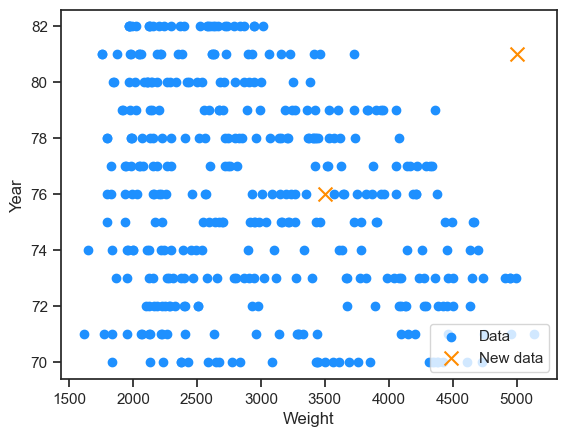

In [20]:
# Plot (optional, using matplotlib)
import matplotlib.pyplot as plt

plt.scatter(autompg['wt'], autompg['year'], color="dodgerblue", label="Data")
plt.scatter(new_cars['wt'], new_cars['year'], color="darkorange", marker='x', s=100, label="New data")
plt.xlabel("Weight")
plt.ylabel("Year")
plt.legend( loc='lower right')
plt.show()


Sin embargo, ahora tenemos que considerar el peso y el año juntos. Y basándonos en el gráfico anterior, uno de los coches nuevos está dentro de la "mancha" de valores observados, mientras que el otro, el coche de 1981 con un peso de 5000 libras, está notablemente fuera de los valores observados. Se trata de una extrapolación oculta que hay que tener en cuenta al utilizar la regresión múltiple.

Cambiando de marcha de nuevo al nuevo par de datos que se puede estimar razonablemente, hacemos una rápida verificación de algunas de las matemáticas en `R`.


In [22]:
import numpy as np

# Define the vector x0
x0 = np.array([1, 3500, 76])

# Compute the matrix multiplication with beta_hat
result = x0 @ beta_hat_manual

print(result)


20.006841079982173



$$ x_{0} = \begin{bmatrix}
1    \\
3500 \\
76   \\
\end{bmatrix}
$$

$$ \hat{\beta} = \begin{bmatrix}
-14.6376419    \\
-0.0066349    \\
0.761402    \\
\end{bmatrix}
$$

$$ \hat{y}(x_0)  = x_{0}^\top\hat{\beta} = 
\begin{bmatrix}
1    &
3500 &
76   \\
\end{bmatrix}
\begin{bmatrix}
-14.6376419    \\
-0.0066349    \\
0.761402    \\
\end{bmatrix}= 20.0068411$$

También tenga en cuenta que, utilizando un valor particular para $x_0$, esencialmente podemos extraer ciertos $\hat{\beta}_j$ valores.

In [24]:
beta_hat_manual

array([-1.46376419e+01, -6.63487587e-03,  7.61401955e-01])


Teniendo esto en cuenta, los intervalos de confianza para el individuo $\hat{\beta}_j$ son en realidad un caso especial de un intervalo de confianza para la respuesta media.



### Intervalos de predicción

Al igual que con SLR, la creación de intervalos de predicción implica un ligero cambio en el error estándar para tener en cuenta el hecho de que ahora estamos considerando una observación, en lugar de una media.

Aquí utilizamos $\hat{y}(x_0)$ para estimar $Y_0$, una nueva observación de $Y$ en el vector predictor $x_0$.
$$
\begin{aligned}
\hat{y}(x_0) &= x_{0}^\top\hat{\beta} \\
&= \hat{\beta}_0 + \hat{\beta}_1 x_{01} + \hat{\beta}_2 x_{02} + \cdots + \hat{\beta}_{p-1} x_{0(p-1)}
\end{aligned}
$$

$$
\begin{aligned}
\text{E}[\hat{y}(x_0)] &= x_{0}^\top\beta \\
&= \beta_0 + \beta_1 x_{01} + \beta_2 x_{02} + \cdots + \beta_{p-1} x_{0(p-1)}
\end{aligned}
$$

Al igual que hicimos con el SLR, debemos tener en cuenta la variabilidad adicional de una observación con respecto a su media.

$$\text{SE}[\hat{y}(x_0) + \epsilon] = s_e \sqrt{1 + x_{0}^\top\left(X^\top X\right)^{-1}x_{0}} $$

Entonces llegamos a nuestro intervalo de predicción actualizado para MLR.

$$ \hat{y}(x_0) \pm t_{\alpha/2, n - p} \cdot s_e \sqrt{1 + x_{0}^\top\left(X^\top X\right)^{-1}x_{0}}$$


In [25]:
predictions = model.get_prediction(new_cars)
prediction_summary = predictions.summary_frame(alpha=0.01)  # 99% confidence
print(prediction_summary)

        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  20.006841  0.206924      19.471198      20.542484     11.108294   
1  13.861537  0.590066      12.334096      15.388979      4.848751   

   obs_ci_upper  
0     28.905388  
1     22.874323  



## Importancia de la regresión

La descomposición de la variación que habíamos visto en SLR sigue siendo válida para MLR.

$$ \sum_{i=1}^{n}(y_i - \bar{y})^2 = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \sum_{i=1}^{n}(\hat{y}_i - \bar{y})^2$$

Es decir,

$$\text{SST} = \text{SSE} + \text{SSReg}.$$

Esto significa que podemos seguir calculando $R^2$ de la misma manera que antes, lo que `Python` sigue haciendo automáticamente.


In [26]:
# Get r-squared

model.rsquared

0.8082354790152035


La interpretación cambia ligeramente en comparación con el SLR. En este caso MLR, decimos que $80.82\%$ de la variación observada en millas por galón se explica por la relación lineal con las dos variables predictoras, peso y año.

En regresión múltiple, la significación de la prueba de regresión es

$$H_0: \beta_1 = \beta_2 = \cdots = \beta_{p - 1} = 0.$$

Aquí, vemos que la hipótesis nula establece todos los $\beta_j$ igual a 0, *excepto* el intercepto, $\beta_0$. Podríamos decir entonces que el modelo nulo, o "modelo bajo la hipótesis nula" es

$$Y_i = \beta_0 + \epsilon_i.$$

Este es un modelo donde la *regresión* es insignificante. **Ninguno** de los predictores tiene una relación lineal significativa con la respuesta. Notablemente, vamos a denotar los valores ajustados de este modelo como $\hat{y}_{0i}$, que en este caso resulta ser:

$$\hat{y}_{0i} = \bar{y}.$$

La hipótesis alternativa aquí es que al menos uno de los $\beta_j$ de la hipótesis nula no es 0.

$$H_1: \text{At least one of } \beta_j \neq 0, j = 1, 2, \cdots, (p-1)$$

Podríamos decir entonces que el modelo completo, o "modelo bajo la hipótesis alternativa" es

$$ Y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_{(p-1)} x_{i(p-1)} + \epsilon_i$$

Este es un modelo donde la regresión es significativa. **Al menos uno** de los predictores tiene una relación lineal significativa con la respuesta. Hay alguna relación lineal entre $y$ y los predictores, $x_1, x_2, \ldots, x_{p - 1}$.

Denotaremos los valores ajustados de este modelo como $\hat{y}_{1i}$.

Para desarrollar la prueba $F$ para la significación de la regresión, vamos a organizar la descomposición de la varianza en una tabla ANOVA.

| Source     | Sum of Squares                             | Degrees of Freedom | Mean Square              | $F$                         |
|--------------|-------------------|--------------|-------------|-------------|
| Regression | $\sum_{i=1}^{n}(\hat{y}_{1i} - \bar{y})^2$ | $p - 1$            | $\text{SSReg} / (p - 1)$ | $\text{MSReg} / \text{MSE}$ |
| Error      | $\sum_{i=1}^{n}(y_i - \hat{y}_{1i})^2$     | $n - p$            | $\text{SSE} / (n - p)$   |                             |
| Total      | $\sum_{i=1}^{n}(y_i - \bar{y})^2$          | $n - 1$            |                          |                             |

En resumen, la estadística $F$ es

$$F = \frac{\sum_{i=1}^{n}(\hat{y}_{1i} - \bar{y})^2 / (p - 1)}{\sum_{i=1}^{n}(y_i - \hat{y}_{1i})^2 / (n - p)},$$

y el valor p se calcula como

$$P(F_{p-1, n-p} > F)$$

ya que rechazamos para valores grandes de $F$. Un valor grande del estadístico corresponde a una gran parte de la varianza explicada por la regresión. Aquí $F_{p-1, n-p}$ representa una variable aleatoria que sigue una distribución $F$ con $p - 1$ y $n - p$ grados de libertad.

Para realizar esta prueba en `Python`, primero especificamos explícitamente los dos modelos en `Python` y guardamos los resultados en variables diferentes. A continuación, utilizamos `anova()` para comparar los dos modelos, dando a `anova()` el modelo nulo en primer lugar y el modelo alternativo (completo) en segundo lugar. (Especificar primero el modelo completo dará como resultado el mismo valor p, pero algunos valores intermedios sin sentido).

En este caso,

-   $H_0$: $Y_i = \beta_0 + \epsilon_i$
-   $H_1$:
    $Y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \epsilon_i$

Es decir, en el modelo nulo, no utilizamos ninguno de los predictores, mientras que en el modelo completo (alternativo), al menos uno de los predictores es útil.

In [27]:
null_mpg_model = sm.OLS(y, sm.add_constant(autompg[[]])).fit()  # Model with only constant
anova_results = sm.stats.anova_lm(null_mpg_model, model)
print(anova_results)

   df_resid           ssr  df_diff       ss_diff           F         Pr(>F)
0     389.0  23761.671897      0.0           NaN         NaN            NaN
1     387.0   4556.645629      2.0  19205.026268  815.550053  1.643078e-139


In [29]:
# Get F-statistic
anova_results['F'][1]

815.5500526702807

de la tabla que nos muestra la funciòn `anova_lm` vemos que el valor del estadístico $F$ es , y el valor p es extremadamente bajo, por lo que rechazamos la hipótesis nula en cualquier $\alpha$ razonable y decimos que la regresión es significativa. Al menos uno de `wt` o `year` tiene una relación lineal útil con `mpg`.


In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     815.6
Date:                Sat, 16 Sep 2023   Prob (F-statistic):          1.64e-139
Time:                        15:59:00   Log-Likelihood:                -1032.7
No. Observations:                 390   AIC:                             2071.
Df Residuals:                     387   BIC:                             2083.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.6376      4.023     -3.638      0.000     -22.548      -6.727
wt            -0.0066      0.000    -30.881      0.000      -0.007      -0.006
year           0.7614      0.050     15.312      0.000       0.664       0.859
==============================================================================
Omnibus:                       41.185   Durbin-Watson:                   1.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.160
Skew:                           0.658   Prob(JB):                     9.60e-16
Kurtosis:                       4.589   Cond. No.                     7.18e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Observe que el valor indicado en la fila de `estadístico F` es realmente el estadístico de prueba $F$ para la prueba de significación de la regresión y, además, indica los dos grados de libertad correspondientes.

Observe también que ninguna de las pruebas $t$ individuales es equivalente a la prueba $F$ como lo eran en SLR. Esta equivalencia sólo es válida para SLR porque la prueba individual para $\beta_1$ es la misma que la prueba para todos los parámetros sin intercepción, ya que sólo hay uno.

También podemos verificar las sumas de cuadrados y los grados de libertad directamente en `python`. En particular, podemos ver que la suma de cuadrados de la regresión es la misma que la suma de cuadrados de la regresión en la tabla ANOVA anterior.

In [31]:
# Calculate additional statistics
SSReg = sum((model.fittedvalues - null_mpg_model.fittedvalues) ** 2)
SSE = sum(model.resid ** 2)
SST = sum((y - y.mean()) ** 2)

print("SSReg:", SSReg)
print("SSE:", SSE)
print("SST:", SST)

SSReg: 19205.026268226196
SSE: 4556.6456292096955
SST: 23761.671897435903


In [32]:
# Degrees of Freedom
DoF_Reg = len(model.params) - len(null_mpg_model.params)
DoF_Error = len(y) - len(model.params)
DoF_Total = len(y) - len(null_mpg_model.params)

print("Degrees of Freedom: Regression:", DoF_Reg)
print("Degrees of Freedom: Error:", DoF_Error)
print("Degrees of Freedom: Total:", DoF_Total)

Degrees of Freedom: Regression: 2
Degrees of Freedom: Error: 387
Degrees of Freedom: Total: 389



## Modelos anidados

La prueba de significación de la regresión es en realidad un caso especial de prueba de lo que llamaremos **modelos anidados**. De forma más general, podemos comparar dos modelos, en los que un modelo está "anidado" dentro del otro, lo que significa que un modelo contiene un subconjunto de predictores sólo del modelo mayor.

Consideremos el siguiente modelo completo,

$$ Y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_{(p-1)} x_{i(p-1)} + \epsilon_i $$

Este modelo tiene $p - 1$ predictores, para un total de $p$ $\beta$ parámetros. Denotaremos los valores ajustados de este modelo como $\hat{y}_{1i}$.

Sea el modelo nulo

$$Y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_{(q-1)} x_{i(q-1)} + \epsilon_i$$

donde $q < p$. Este modelo tiene $q - 1$ predictores, para un total de $q$ $\beta$-parámetros. Denotaremos los valores ajustados de este modelo como $\hat{y}_{0i}$.

La diferencia entre estos dos modelos puede codificarse mediante la hipótesis nula de una prueba.

$$H_0: \beta_q = \beta_{q+1} = \cdots = \beta_{p - 1} = 0. $$

En concreto, los parámetros $\beta$ del modelo completo que no están en el modelo nulo son cero. El modelo resultante, que está anidado, es el modelo nulo.

A continuación, podemos realizar esta prueba utilizando una prueba $F$, que es el resultado de la siguiente tabla ANOVA.

| Source | Sum of Squares                                  | Degrees of Freedom | Mean Square            | $F$                       |
|----------|---------------------|---------------|--------------|--------------|
| Diff   | $\sum_{i=1}^{n}(\hat{y}_{1i} - \hat{y}_{0i})^2$ | $p - q$            | $\text{SSD} / (p - q)$ | $\text{MSD} / \text{MSE}$ |
| Full   | $\sum_{i=1}^{n}(y_i - \hat{y}_{1i})^2$          | $n - p$            | $\text{SSE} / (n - p)$ |                           |
| Null   | $\sum_{i=1}^{n}(y_i - \hat{y}_{0i})^2$          | $n - q$            |                        |                           |

$$ F = \frac{\sum_{i=1}^{n}(\hat{y}_{1i} - \hat{y}_{0i})^2 / (p - q)}{\sum_{i=1}^{n}(y_i - \hat{y}_{1i})^2 / (n - p)}.$$

Observe que la fila "Diff" compara la suma de las diferencias al cuadrado de los valores ajustados. Los grados de libertad son entonces la diferencia del número de parámetros $\beta$ estimados entre los dos modelos.

Por ejemplo, el conjunto de datos `autompg` tiene una serie de variables adicionales que aún no hemos utilizado.

In [33]:
# names of columns
autompg.columns

Index(['mpg', 'cyl', 'disp', 'hp', 'wt', 'acc', 'year'], dtype='object')


Seguiremos utilizando `mpg` como respuesta, pero ahora consideraremos dos modelos diferentes.

-   Completo: `mpg ~ wt + year + cyl + disp + hp + acc`
-   Nulo: `mpg ~ wt + year`

Obsérvese que se trata de modelos anidados, ya que el modelo nulo contiene un subconjunto de predictores del modelo completo y ningún predictor adicional. Ambos modelos tienen un intercepto $\beta_0$ así como un coeficiente delante de cada uno de los predictores. Podríamos entonces escribir la hipótesis nula para comparar estos dos modelos como,

$$ H_0: \beta_{\texttt{cyl}} = \beta_{\texttt{disp}} = \beta_{\texttt{hp}} = \beta_{\texttt{acc}} = 0 $$

La alternativa es simplemente que al menos uno de los $\beta_{j}$ del nulo no sea 0.

Para realizar esta prueba en `Python` primero definimos ambos modelos, luego se los damos a los comandos `anova_lm()`.


In [38]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Generate the formula string for the full model
dependent_var = 'mpg'
independent_vars = autompg.columns.drop(dependent_var).tolist()
full_formula = dependent_var + ' ~ ' + ' + '.join(independent_vars)

# Define the null model
null_mpg_model = smf.ols('mpg ~ wt + year', data=autompg).fit()

# Define the full model using the generated formula
full_mpg_model = smf.ols(full_formula, data=autompg).fit()

# Compare the models using an ANOVA test
anova_results = sm.stats.anova_lm(null_mpg_model, full_mpg_model)

print(anova_results)






   df_resid          ssr  df_diff    ss_diff         F    Pr(>F)
0     387.0  4556.645629      0.0        NaN       NaN       NaN
1     383.0  4530.465818      4.0  26.179812  0.553302  0.696725


- Utilizamos `statsmodels.formula.api` (importado como smf) cuando queremos definir modelos utilizando cadenas de fórmulas similares a R.
- `smf.ols('mpg ~ .', data=autompg).fit()` define un modelo con mpg como respuesta y todas las demás columnas de autompg como predictores.
- `sm.stats.anova_lm` se utiliza para comparar los modelos, e imprimirá una tabla mostrando los resultados de la prueba ANOVA.

**Volviendo a los resultados**


Aquí vemos que el valor del estadístico $F$ es 0.55, y el valor p es muy grande, por lo que no podemos rechazar la hipótesis nula en ningún $\alpha$ razonable y decimos que ninguna de `cyl`, `disp`, `hp`, y `acc` son significativas con `wt` y `year` ya en el modelo.

